# NHIS - Data explore

**Goals** 
* Understand the NHIS dataset fields, focused on neurodiversity related felds
* Come up with scripts to transform and impute values prior to further exploration or prediction
* Run simple correlation & regression analysis


**Notable assumptions being made**
* Sample data from has similar distribution as general US population (e.g. income class, region)
* We will use ADHDEV_C (ADHD) and ASDEV_C (Autistic Spectrum Disorder) as the main target labels for exploration & analysis

## Results/insights summary

* Few transformations done/proposed prior to further analysis
* There are rotating questions that only happens once every few years
* ASD, ADHD question is not being asked in adults dataset

## Imports and initializations

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import statsmodels.api as sm
import seaborn as sns


import os
        
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from phik import phik_matrix
from scipy.stats import chi2_contingency

In [2]:
pd.set_option('display.max_rows', 500)  # Set the option to display all rows
pd.set_option('display.max_columns', 100)  # Set the option to display all rows

#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')

In [3]:
#import data and reserve the originals as read only

dfc22_orig = pd.read_csv('source/child22.csv')
dfa22_orig = pd.read_csv('source/adult22.csv')
dfc21_orig = pd.read_csv('source/child21.csv')
dfa21_orig = pd.read_csv('source/adult21.csv')
dfc20_orig = pd.read_csv('source/child20.csv')
dfa20_orig = pd.read_csv('source/adult20.csv')
dfc19_orig = pd.read_csv('source/child19.csv')
dfa19_orig = pd.read_csv('source/adult19.csv')



#Copying to working dataframe, also removing columns not planned to be used
#Fields to be extracted are decided on a separate spreadsheet
dfc22 = dfc22_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_C', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_C', 'RELTIVP_C', 'SEX_C', 'AGEP_C', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_C', 'PCNTKIDS_C', 'OVER65FLG_C', 'MLTFAMFLG_C', 'PHSTAT_C', 'LSATIS11_C', 'ADHDEV_C', 'ADHDNW_C', 'IDEV1_C', 'IDNW1_C', 'ASDEV_C', 'ASDNW_C', 'DDEV_C', 'DDNW_C', 'LDEV_C', 'LDNW_C', 'BMICAT_C', 'WEARGLSS_C', 'VISIONDF_C', 'HEARINGDF_C', 'UNDRSTYOU_C', 'UNDRSTCHD_C', 'UNDRSTIHH_C', 'UNDRSTOHH_C', 'LEARNDF_C', 'REMEMBERDF_C', 'ANXFREQ_C', 'DEPFREQ_C', 'BEHDFPLYG_C', 'BEHKBHYG_C', 'BEHDFCNTR_C', 'BEHDFFCS_C', 'BEHDFCHG_C', 'BEHDFMKFR_C', 'BSCNWPPL_C', 'BSCNWPLCS_C', 'BSCCHG_C', 'BSCHLOPPL_C', 'BSCCRYALT_C', 'BSCCLMDWN_C', 'BSCFUSSY_C', 'BSCSTHE_C', 'BSCSCHD_C', 'BSCPTSLP_C', 'BSCSTYSLP_C', 'SCHSPEDEV_C', 'SCHSPED_C', 'SCHSPEDEM_C', 'SDQ1_C', 'SDQ2_C', 'SDQ3_C', 'SDQ4_C', 'SDQ5_C', 'SDQ6_C', 'SDQ7_C', 'SDQ8_C', 'SDQ9_C', 'SDQ10_C', 'SDQ11_C', 'SDQ12_C', 'SDQ13_C', 'SDQ14_C', 'SDQ15_C', 'SDQ16_C', 'SDQ17_C', 'SDQ18_C', 'SDQ19_C', 'SDQ20_C', 'SDQ21_C', 'SDQ22_C', 'SDQ23_C', 'SDQ24_C', 'SDQ25_C', 'SDQIMP1_C', 'SDQIMP2_C', 'SDQIMP3_C', 'SDQIMP4_C', 'SDQIMP5_C', 'SDQIMP6_C', 'SDQIMP7_C', 'SDQIMP8_C', 'SDQEMOT_C', 'SDQCOND_C', 'SDQHYPE_C', 'SDQPEER_C', 'SDQPROS_C', 'SDQTOT_C', 'SDQIMPTOT_C', 'VIOLENEV_C', 'JAILEV1_C', 'MENTDEPEV_C', 'ALCDRUGEV_C', 'PUTDOWN_C', 'BNEEDS_C', 'UNFAIRRE_C', 'UNFAIRSO_C', 'BULLYVIC_C', 'CYBERVIC_C', 'BULLYPERP_C', 'TBILOSTCON_C', 'TBIDAZED_C', 'POVRATTC_C', 'RATCAT_C']].copy()
dfc21 = dfc21_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_C', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_C', 'RELTIVP_C', 'SEX_C', 'AGEP_C', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_C', 'PCNTKIDS_C', 'OVER65FLG_C', 'MLTFAMFLG_C', 'PHSTAT_C', 'LSATIS11_C', 'ADHDEV_C', 'ADHDNW_C', 'ASDEV_C', 'ASDNW_C', 'DDEV_C', 'DDNW_C', 'LDEV_C', 'LDNW_C', 'WEARGLSS_C', 'VISIONDF_C', 'HEARINGDF_C', 'UNDRSTYOU_C', 'UNDRSTCHD_C', 'UNDRSTIHH_C', 'UNDRSTOHH_C', 'LEARNDF_C', 'REMEMBERDF_C', 'ANXFREQ_C', 'DEPFREQ_C', 'BEHDFPLYG_C', 'BEHKBHYG_C', 'BEHDFCNTR_C', 'BEHDFFCS_C', 'BEHDFCHG_C', 'BEHDFMKFR_C', 'BSCNWPPL_C', 'BSCNWPLCS_C', 'BSCCHG_C', 'BSCHLOPPL_C', 'BSCCRYALT_C', 'BSCCLMDWN_C', 'BSCFUSSY_C', 'BSCSTHE_C', 'BSCSCHD_C', 'BSCPTSLP_C', 'BSCSTYSLP_C', 'SCHSPEDEV_C', 'SCHSPED_C', 'SCHSPEDEM_C', 'VIOLENEV_C', 'JAILEV1_C', 'MENTDEPEV_C', 'ALCDRUGEV_C', 'PUTDOWN_C', 'BNEEDS_C', 'UNFAIRRE_C', 'UNFAIRSO_C', 'BULLYVIC_C', 'CYBERVIC_C', 'BULLYPERP_C', 'TBILOSTCON_C', 'TBIDAZED_C', 'POVRATTC_C', 'RATCAT_C']].copy()
dfc20 = dfc20_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_C', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_C', 'RELTIVP_C', 'SEX_C', 'AGEP_C', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_C', 'PCNTKIDS_C', 'OVER65FLG_C', 'MLTFAMFLG_C', 'PHSTAT_C', 'ADHDEV_C', 'ADHDNW_C', 'ASDEV_C', 'ASDNW_C', 'DDEV_C', 'DDNW_C', 'LDEV_C', 'LDNW_C', 'BMICAT_C', 'WEARGLSS_C', 'VISIONDF_C', 'HEARINGDF_C', 'UNDRSTYOU_C', 'UNDRSTCHD_C', 'UNDRSTIHH_C', 'UNDRSTOHH_C', 'LEARNDF_C', 'REMEMBERDF_C', 'ANXFREQ_C', 'DEPFREQ_C', 'BEHDFPLYG_C', 'BEHKBHYG_C', 'BEHDFCNTR_C', 'BEHDFFCS_C', 'BEHDFCHG_C', 'BEHDFMKFR_C', 'BSCNWPPL_C', 'BSCNWPLCS_C', 'BSCCHG_C', 'BSCHLOPPL_C', 'BSCCRYALT_C', 'BSCCLMDWN_C', 'BSCFUSSY_C', 'BSCSTHE_C', 'BSCSCHD_C', 'BSCPTSLP_C', 'BSCSTYSLP_C', 'SCHSPEDEV_C', 'SCHSPED_C', 'SCHSPEDEM_C', 'TBILOSTCON_C', 'TBIDAZED_C', 'POVRATTC_C', 'RATCAT_C']].copy()
dfc19 = dfc19_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_C', 'REGION', 'INTV_QRT', 'HHSTAT_C', 'RELTIVP_C', 'SEX_C', 'AGEP_C', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_C', 'PCNTKIDS_C', 'OVER65FLG_C', 'MLTFAMFLG_C', 'PHSTAT_C', 'ADHDEV_C', 'ADHDNW_C', 'ASDEV_C', 'ASDNW_C', 'DDEV_C', 'DDNW_C', 'LDEV_C', 'LDNW_C', 'WEARGLSS_C', 'VISIONDF_C', 'HEARINGDF_C', 'UNDRSTYOU_C', 'UNDRSTCHD_C', 'UNDRSTIHH_C', 'UNDRSTOHH_C', 'LEARNDF_C', 'REMEMBERDF_C', 'ANXFREQ_C', 'DEPFREQ_C', 'BEHDFPLYG_C', 'BEHKBHYG_C', 'BEHDFCNTR_C', 'BEHDFFCS_C', 'BEHDFCHG_C', 'BEHDFMKFR_C', 'BSCNWPPL_C', 'BSCNWPLCS_C', 'BSCCHG_C', 'BSCHLOPPL_C', 'BSCCRYALT_C', 'BSCCLMDWN_C', 'BSCFUSSY_C', 'BSCSTHE_C', 'BSCSCHD_C', 'BSCPTSLP_C', 'BSCSTYSLP_C', 'SCHSPEDEV_C', 'SCHSPED_C', 'SCHSPEDEM_C', 'SDQ1_C', 'SDQ2_C', 'SDQ3_C', 'SDQ4_C', 'SDQ5_C', 'SDQ6_C', 'SDQ7_C', 'SDQ8_C', 'SDQ9_C', 'SDQ10_C', 'SDQ11_C', 'SDQ12_C', 'SDQ13_C', 'SDQ14_C', 'SDQ15_C', 'SDQ16_C', 'SDQ17_C', 'SDQ18_C', 'SDQ19_C', 'SDQ20_C', 'SDQ21_C', 'SDQ22_C', 'SDQ23_C', 'SDQ24_C', 'SDQ25_C', 'SDQIMP1_C', 'SDQIMP2_C', 'SDQIMP3_C', 'SDQIMP4_C', 'SDQIMP5_C', 'SDQIMP6_C', 'SDQIMP7_C', 'SDQIMP8_C', 'SDQEMOT_C', 'SDQCOND_C', 'SDQHYPE_C', 'SDQPEER_C', 'SDQPROS_C', 'SDQTOT_C', 'SDQIMPTOT_C', 'VIOLENEV_C', 'MENTDEPEV_C', 'ALCDRUGEV_C', 'POVRATTC_C', 'RATCAT_C']].copy()


dfa22 = dfa22_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_A', 'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65', 'RACEALLP_A', 'EDUCP_A', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_A', 'PCNTKIDS_A', 'OVER65FLG_A', 'PHSTAT_A', 'LSATIS4_A', 'HYPEV_A', 'HYPDIF_A', 'HYP12M_A', 'ANXEV_A', 'DEPEV_A', 'COMDIFF_A', 'COGMEMDFF_A', 'COGTYPEDFF_A', 'COGFRQDFF_A', 'COGAMTDFF_A', 'OGHDHP_A', 'PLEXCHOG_A', 'OGFLG_A', 'MILITARY_A', 'MILSPC1R_A', 'MILSPC2_A', 'MILSPC3_A', 'IHS_A', 'HILAST_A', 'HILASTMY_A', 'HISTOPJOB_A', 'HISTOPMISS_A', 'HISTOPAGE_A', 'HISTOPCOST_A', 'HISTOPELIG_A', 'RSNHICOST_A', 'RSNHIWANT_A', 'RSNHIELIG_A', 'RSNHICONF_A', 'RSNHIMEET_A', 'RSNHIWAIT_A', 'RSNHIOTH_A', 'RSNHIJOB_A', 'RSNHIMISS_A', 'HINOTYR_A', 'HINOTMYR_A', 'MILSPC1_A', 'HICOV_A', 'HIKIND01_A', 'HIKIND02_A', 'HIKIND03_A', 'HIKIND04_A', 'HIKIND05_A', 'HIKIND06_A', 'HIKIND07_A', 'HIKIND08_A', 'HIKIND09_A', 'HIKIND10_A', 'MCAREPRB_A', 'MCAIDPRB_A', 'PAYBLL12M_A', 'PAYNOBLLNW_A', 'PAYWORRY_A', 'CVDDIAG_A', 'POSTEST_A', 'CVDSEV_A', 'LONGCVD_A', 'SYMPNOW_A', 'DENPREV_A', 'DENDL12M_A', 'DENNG12M_A', 'LASTDR_A', 'WELLNESS_A', 'ANXFREQ_A', 'ANXMED_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'MHRX_A', 'MHTHRPY_A', 'MHTPYNOW_A', 'PHQ81_A', 'PHQ82_A', 'PHQ83_A', 'PHQ84_A', 'PHQ85_A', 'PHQ86_A', 'PHQ87_A', 'PHQ88_A', 'PHQCAT_A', 'GAD71_A', 'GAD72_A', 'GAD73_A', 'GAD74_A', 'GAD75_A', 'GAD76_A', 'GAD77_A', 'GADCAT_A', 'SMKTLK1_A', 'ECIGEV_A', 'CIGARCUR_A']].copy()
dfa21 = dfa21_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_A', 'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65', 'RACEALLP_A', 'EDUCP_A', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_A', 'PCNTKIDS_A', 'OVER65FLG_A', 'PHSTAT_A', 'HYPEV_A', 'HYPDIF_A', 'HYP12M_A', 'ANXEV_A', 'DEPEV_A', 'COMDIFF_A', 'COGMEMDFF_A', 'COGTYPEDFF_A', 'COGFRQDFF_A', 'COGAMTDFF_A', 'OGHDHP_A', 'PLEXCHOG_A', 'OGFLG_A', 'MILITARY_A', 'MILSPC1R_A', 'MILSPC2_A', 'MILSPC3_A', 'IHS_A', 'HILAST_A', 'HILASTMY_A', 'HISTOPJOB_A', 'HISTOPMISS_A', 'HISTOPAGE_A', 'HISTOPCOST_A', 'HISTOPELIG_A', 'RSNHICOST_A', 'RSNHIWANT_A', 'RSNHIELIG_A', 'RSNHICONF_A', 'RSNHIMEET_A', 'RSNHIWAIT_A', 'RSNHIOTH_A', 'RSNHIJOB_A', 'RSNHIMISS_A', 'HINOTYR_A', 'HINOTMYR_A', 'MILSPC1_A', 'HICOV_A', 'HIKIND01_A', 'HIKIND02_A', 'HIKIND03_A', 'HIKIND04_A', 'HIKIND05_A', 'HIKIND06_A', 'HIKIND07_A', 'HIKIND08_A', 'HIKIND09_A', 'HIKIND10_A', 'MCAREPRB_A', 'MCAIDPRB_A', 'PAYBLL12M_A', 'PAYNOBLLNW_A', 'PAYWORRY_A', 'CVDDIAG_A', 'CVDSEV_A', 'LASTDR_A', 'WELLNESS_A', 'ANXFREQ_A', 'ANXMED_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'MHRX_A', 'MHTHRPY_A', 'MHTPYNOW_A', 'ECIGEV_A', 'CIGARCUR_A']].copy()
dfa20 = dfa20_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_A', 'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65', 'RACEALLP_A', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_A', 'PCNTKIDS_A', 'OVER65FLG_A', 'PHSTAT_A', 'HYPEV_A', 'HYPDIF_A', 'HYP12M_A', 'ANXEV_A', 'DEPEV_A', 'COMDIFF_A', 'COGMEMDFF_A', 'COGTYPEDFF_A', 'COGFRQDFF_A', 'COGAMTDFF_A', 'OGHDHP_A', 'PLEXCHOG_A', 'OGFLG_A', 'MILITARY_A', 'MILSPC1R_A', 'MILSPC2_A', 'MILSPC3_A', 'IHS_A', 'HILAST_A', 'HILASTMY_A', 'HISTOPJOB_A', 'HISTOPMISS_A', 'HISTOPAGE_A', 'HISTOPCOST_A', 'HISTOPELIG_A', 'RSNHICOST_A', 'RSNHIWANT_A', 'RSNHIELIG_A', 'RSNHICONF_A', 'RSNHIMEET_A', 'RSNHIWAIT_A', 'RSNHIOTH_A', 'RSNHIJOB_A', 'RSNHIMISS_A', 'HINOTYR_A', 'HINOTMYR_A', 'MILSPC1_A', 'HICOV_A', 'HIKIND01_A', 'HIKIND02_A', 'HIKIND03_A', 'HIKIND04_A', 'HIKIND05_A', 'HIKIND06_A', 'HIKIND07_A', 'HIKIND08_A', 'HIKIND09_A', 'HIKIND10_A', 'MCAREPRB_A', 'MCAIDPRB_A', 'PAYBLL12M_A', 'PAYNOBLLNW_A', 'PAYWORRY_A', 'CVDDIAG_A', 'CVDSEV_A', 'DENPREV_A', 'DENDL12M_A', 'DENNG12M_A', 'LASTDR_A', 'WELLNESS_A', 'ANXFREQ_A', 'ANXMED_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'MHRX_A', 'MHTHRPY_A', 'MHTPYNOW_A', 'ECIGEV_A', 'CIGARCUR_A']].copy()
dfa19 = dfa19_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'REGION', 'INTV_QRT', 'HHSTAT_A', 'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65', 'RACEALLP_A', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_A', 'PCNTKIDS_A', 'OVER65FLG_A', 'PHSTAT_A', 'HYPEV_A', 'HYPDIF_A', 'HYP12M_A', 'ANXEV_A', 'DEPEV_A', 'COMDIFF_A', 'COGMEMDFF_A', 'COGTYPEDFF_A', 'COGFRQDFF_A', 'COGAMTDFF_A', 'OGHDHP_A', 'PLEXCHOG_A', 'OGFLG_A', 'MILITARY_A', 'MILSPC1R_A', 'MILSPC2_A', 'MILSPC3_A', 'IHS_A', 'HILAST_A', 'HILASTMY_A', 'HISTOPJOB_A', 'HISTOPMISS_A', 'HISTOPAGE_A', 'HISTOPCOST_A', 'HISTOPELIG_A', 'RSNHICOST_A', 'RSNHIWANT_A', 'RSNHIELIG_A', 'RSNHICONF_A', 'RSNHIMEET_A', 'RSNHIWAIT_A', 'RSNHIOTH_A', 'RSNHIJOB_A', 'RSNHIMISS_A', 'HINOTYR_A', 'HINOTMYR_A', 'MILSPC1_A', 'HICOV_A', 'HIKIND01_A', 'HIKIND02_A', 'HIKIND03_A', 'HIKIND04_A', 'HIKIND05_A', 'HIKIND06_A', 'HIKIND07_A', 'HIKIND08_A', 'HIKIND09_A', 'HIKIND10_A', 'MCAREPRB_A', 'MCAIDPRB_A', 'PAYBLL12M_A', 'PAYNOBLLNW_A', 'PAYWORRY_A', 'DENPREV_A', 'DENDL12M_A', 'DENNG12M_A', 'LASTDR_A', 'WELLNESS_A', 'ANXFREQ_A', 'ANXMED_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'MHRX_A', 'MHTHRPY_A', 'MHTPYNOW_A', 'PHQ81_A', 'PHQ82_A', 'PHQ83_A', 'PHQ84_A', 'PHQ85_A', 'PHQ86_A', 'PHQ87_A', 'PHQ88_A', 'PHQCAT_A', 'GAD71_A', 'GAD72_A', 'GAD73_A', 'GAD74_A', 'GAD75_A', 'GAD76_A', 'GAD77_A', 'GADCAT_A', 'ECIGEV_A', 'CIGARCUR_A']].copy()

#dfcall = pd.concat([dfc22,dfc21,dfc20,dfc19],axis=0)
dfcall = pd.concat([dfc22,dfc21,dfc20,dfc19],axis=0)

dfaall = pd.concat([dfa22,dfa21,dfa20,dfa19],axis=0)


In [4]:
#Also importing the column description table so it's easier to refer to
cookbook_child = pd.read_csv('source/child-summary.csv')

In [5]:
#Checking shape
print(f"Child shape: {dfc22.shape} \nAdult shape: {dfa22.shape}")

Child shape: (7464, 116) 
Adult shape: (27651, 115)


# Child

## Missing/null values

In [6]:
#Checking null values & percentages

num_of_rows = dfcall.shape[0]

dfc_nullcheck = pd.DataFrame(dfcall.isna().sum().reset_index())
dfc_nullcheck = dfc_nullcheck.rename({0:'nulls'},axis=1)
dfc_nullcheck['percentage'] = dfc_nullcheck['nulls'] / num_of_rows
dfc_nullcheck['description'] = pd.merge(dfc_nullcheck, cookbook_child, left_on='index', right_on='Variable Name')['Description']
dfc_nullcheck.sort_values('percentage',ascending=False)

,index,nulls,percentage,description
22,IDNW1_C,30590,0.996157,Currently has intellectual disability
24,ASDNW_C,29818,0.971017,Currently has autism
26,DDNW_C,29153,0.949362,Currently has developmental delay
28,LDNW_C,28726,0.935457,Currently has learning disability
20,ADHDNW_C,28053,0.913540,Currently has ADD/ADHD
60,SCHSPEDEM_C,27915,0.909047,Currently receives services for mental health
53,BSCFUSSY_C,27378,0.891559,Fussy or irritable
54,BSCSTHE_C,27378,0.891559,Hard to comfort
55,BSCSCHD_C,27378,0.891559,Hard to keep on schedule
56,BSCPTSLP_C,27378,0.891559,Hard to put to sleep


### Observations/Notes

* Questions such as having ADHD or Autisma have very high % of data missing (vetted with NHIS' original document). After quick analysis, determined the "Currently has autism" question will be skipped if the user answered No to "Ever had autism" question. Therefore we can assume null = No for "Currently has autism question"
* SDQ questions and few other questions only happen every 3 years, so currentyly we only have them for 2019 and 2022


## BSC* fields


In [7]:
#Comparing data when the BSC fields are blank VS not blank. 
pd.concat([dfc22[~dfc22['BSCHLOPPL_C'].isna()].head(10),dfc22[dfc22['BSCHLOPPL_C'].isna()].head(10)],axis=0)

,RECTYPE,SRVY_YR,HHX,WTFA_C,REGION,INTV_QRT,INTV_MON,HHSTAT_C,RELTIVP_C,SEX_C,AGEP_C,PCNTLT18TC,PCNT18UPTC,PCNTADLT_C,PCNTKIDS_C,OVER65FLG_C,MLTFAMFLG_C,PHSTAT_C,LSATIS11_C,ADHDEV_C,ADHDNW_C,IDEV1_C,IDNW1_C,ASDEV_C,ASDNW_C,DDEV_C,DDNW_C,LDEV_C,LDNW_C,BMICAT_C,WEARGLSS_C,VISIONDF_C,HEARINGDF_C,UNDRSTYOU_C,UNDRSTCHD_C,UNDRSTIHH_C,UNDRSTOHH_C,LEARNDF_C,REMEMBERDF_C,ANXFREQ_C,DEPFREQ_C,BEHDFPLYG_C,BEHKBHYG_C,BEHDFCNTR_C,BEHDFFCS_C,BEHDFCHG_C,BEHDFMKFR_C,BSCNWPPL_C,BSCNWPLCS_C,BSCCHG_C,...,SDQ6_C,SDQ7_C,SDQ8_C,SDQ9_C,SDQ10_C,SDQ11_C,SDQ12_C,SDQ13_C,SDQ14_C,SDQ15_C,SDQ16_C,SDQ17_C,SDQ18_C,SDQ19_C,SDQ20_C,SDQ21_C,SDQ22_C,SDQ23_C,SDQ24_C,SDQ25_C,SDQIMP1_C,SDQIMP2_C,SDQIMP3_C,SDQIMP4_C,SDQIMP5_C,SDQIMP6_C,SDQIMP7_C,SDQIMP8_C,SDQEMOT_C,SDQCOND_C,SDQHYPE_C,SDQPEER_C,SDQPROS_C,SDQTOT_C,SDQIMPTOT_C,VIOLENEV_C,JAILEV1_C,MENTDEPEV_C,ALCDRUGEV_C,PUTDOWN_C,BNEEDS_C,UNFAIRRE_C,UNFAIRSO_C,BULLYVIC_C,CYBERVIC_C,BULLYPERP_C,TBILOSTCON_C,TBIDAZED_C,POVRATTC_C,RATCAT_C
7,20,2022,H019456,5445.846,4,1,1,1,2,2,1,2,3,3,2,0,2,1,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2,2.0,3.62,11
8,20,2022,H006250,2926.150,4,1,1,1,1,2,1,2,2,2,2,0,2,2,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2,2.0,3.63,11
33,20,2022,H015664,9269.168,4,1,1,1,1,2,1,2,1,1,2,0,2,2,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,7,7,2,2,2,2,NaN,NaN,NaN,NaN,2,2.0,0.63,2
36,20,2022,H025236,2800.267,4,1,1,1,1,2,0,1,2,2,1,0,2,1,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2,2.0,11.00,14
46,20,2022,H046500,3889.308,4,1,1,1,1,2,1,1,2,2,1,0,2,1,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2,2.0,3.66,11
47,20,2022,H038806,4869.496,4,1,1,1,1,1,0,1,2,2,1,0,2,1,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2,2.0,5.96,14
50,20,2022,H002157,6430.208,4,1,1,1,1,1,0,2,3,2,2,0,1,3,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2,2.0,4.91,13
52,20,2022,H028273,3523.654,4,1,1,1,1,1,0,1,3,3,1,0,2,1,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2,2.0,2.99,9
56,20,2022,H040247,4186.175,4,1,1,1,1,2,0,1,3,3,1,0,2,3,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,Na

### Observations
* Records that have BSC fields filled in are children that's 1 or younger (possibly 2). 

In [8]:
# Checking the NA value differences per age

dfc22.groupby('AGEP_C').apply(lambda x: x.isnull().sum())

,RECTYPE,SRVY_YR,HHX,WTFA_C,REGION,INTV_QRT,INTV_MON,HHSTAT_C,RELTIVP_C,SEX_C,AGEP_C,PCNTLT18TC,PCNT18UPTC,PCNTADLT_C,PCNTKIDS_C,OVER65FLG_C,MLTFAMFLG_C,PHSTAT_C,LSATIS11_C,ADHDEV_C,ADHDNW_C,IDEV1_C,IDNW1_C,ASDEV_C,ASDNW_C,DDEV_C,DDNW_C,LDEV_C,LDNW_C,BMICAT_C,WEARGLSS_C,VISIONDF_C,HEARINGDF_C,UNDRSTYOU_C,UNDRSTCHD_C,UNDRSTIHH_C,UNDRSTOHH_C,LEARNDF_C,REMEMBERDF_C,ANXFREQ_C,DEPFREQ_C,BEHDFPLYG_C,BEHKBHYG_C,BEHDFCNTR_C,BEHDFFCS_C,BEHDFCHG_C,BEHDFMKFR_C,BSCNWPPL_C,BSCNWPLCS_C,BSCCHG_C,...,SDQ6_C,SDQ7_C,SDQ8_C,SDQ9_C,SDQ10_C,SDQ11_C,SDQ12_C,SDQ13_C,SDQ14_C,SDQ15_C,SDQ16_C,SDQ17_C,SDQ18_C,SDQ19_C,SDQ20_C,SDQ21_C,SDQ22_C,SDQ23_C,SDQ24_C,SDQ25_C,SDQIMP1_C,SDQIMP2_C,SDQIMP3_C,SDQIMP4_C,SDQIMP5_C,SDQIMP6_C,SDQIMP7_C,SDQIMP8_C,SDQEMOT_C,SDQCOND_C,SDQHYPE_C,SDQPEER_C,SDQPROS_C,SDQTOT_C,SDQIMPTOT_C,VIOLENEV_C,JAILEV1_C,MENTDEPEV_C,ALCDRUGEV_C,PUTDOWN_C,BNEEDS_C,UNFAIRRE_C,UNFAIRSO_C,BULLYVIC_C,CYBERVIC_C,BULLYPERP_C,TBILOSTCON_C,TBIDAZED_C,POVRATTC_C,RATCAT_C
AGEP_C,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,417,417,417,0,417,417,417,0,413,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,0,0,0,...,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,0,0,0,0,0,0,0,417,417,417,417,0,3,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,414,414,414,0,413,414,414,0,399,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,0,0,0,...,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,0,0,0,0,0,0,0,414,414,414,414,0,3,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,362,0,362,0,358,0,351,0,339,0,355,362,0,0,0,0,0,362,362,0,362,362,362,0,0,362,362,362,362,362,362,362,...,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,0,0,0,0,0,0,0,362,362,362,362,0,3,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,389,0,385,0,386,0,381,0,362,0,380,389,0,0,0,0,0,389,389,0,389,389,389,0,0,389,389,389,389,389,389,389,...,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,0,0,0,0,0,0,0,389,389,389,389,0,6,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,384,0,378,0,375,0,371,0,355,0,372,384,0,0,0,0,0,384,384,0,384,384,384,0,0,384,384,384,384,384,384,384,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,277,277,277,277,277,277,277,0,0,0,0,0,0,277,0,0,0,0,0,0,0,384,384,384,384,0,6,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,425,0,415,0,421,0,404,0,398,0,412,425,0,0,0,425,425,0,0,0,0,0,0,425,425,0,0,0,0,425,425,425,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,307,307,307,307,307,307,307,0,0,0,0,0,0,307,0,0,0,0,0,0,0,425,425,425,425,0,13,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,397,0,368,0,392,0,388,0,382,0,379,397,0,0,0,397,397,0,0,0,0,0,0,397,397,0,0,0,0,397,397,397,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,263,263,263,263,263,263,263,0,0,0,0,0,0,263,0,0,0,0,0,0,0,397,397,397,397,0,6,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,380,0,354,0,378,0,366,0,349,0,353,380,0,0,0,380,380,0,0,0,0,0,0,380,380,0,0,0,0,380,380,380,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,264,264,264,264,264,264,264,0,0,0,0,0,0,264,0,0,0,0,0,0,0,380,380,380,380,0,15,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,353,0,306,0,349,0,342,0,337,0,321,353,0,0,0,353,353,0,0,0,0,0,0,353,353,0,0,0,0,353,353,353,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236,236,236,236,236,236,236,0,0,0,0,0,0,236,0,0,0,0,0,0,0,353,353,353,353,0,11,0,0


As suspected, different questions are answered based on age. 
There seems to be different set of questions from: 
* 0-1
* 2-4
* 5-17 (SUPPORT_C and COMSUPPORT_C is not answered above 12, presumably by some age limits)

## Data transformation

### Modifying values based on type of question
*Note: Modifications are based on at the codebook*

In [15]:
# Identifying columns to transform based on the max value for the column
column_maxes = (dfcall.describe().transpose().reset_index()).loc[:,['index','max']].sort_values(by='max',ascending=False)

# If max is 2.0, then it's binary. Changing it to 0 VS 1 (instead of 1 VS 2)
binaries = column_maxes.loc[column_maxes['max'].isin([2.0]),'index'].tolist()
for column in binaries:
    dfcall.loc[dfcall[column].isin([2.0]),column] = 0.0

# If max value is 8 or 9, then it is an ordinal value (1~5 OR 1~3), with 7 = refused, 8 = not ascertained, 9 = Don't know. We are going to change these to null
max_eight_or_nines = column_maxes.loc[column_maxes['max'].isin([7.0,8.0,9.0]),'index'].tolist()
for column in max_eight_or_nines:
    dfcall.loc[dfcall[column].isin([7.0,8.0,9.0]),column] = None

# If max value = 88 or 99, that column is a numeric field (e.g. SQD impact score), but 88 being "Not ascertained" or 99 not sure. Therefore, changing it to null
max_eighty_eights = column_maxes.loc[column_maxes['max'] ==88,'index'].tolist()
for column in max_eighty_eights:
    dfcall.loc[dfcall[column] == 88,column] = None
    dfcall.loc[dfcall[column] == 88,column] = None


## Trend analysis

In [10]:

dfcall_yearly = pd.DataFrame(dfcall['SRVY_YR'].sort_values().unique(),columns=['year'])
dfcall_yearly['all_count'] = pd.DataFrame(dfcall.groupby('SRVY_YR')['ADHDEV_C'].count().reset_index())['ADHDEV_C']
dfcall_yearly['adhd_count'] = pd.DataFrame(dfcall.loc[dfcall['ADHDEV_C']==1.0,['SRVY_YR','ADHDEV_C']].groupby('SRVY_YR')['ADHDEV_C'].count().reset_index())['ADHDEV_C']
dfcall_yearly['asd_count'] = pd.DataFrame(dfcall.loc[dfcall['ASDEV_C']==1.0,['SRVY_YR','ASDEV_C']].groupby('SRVY_YR')['ASDEV_C'].count().reset_index())['ASDEV_C']
dfcall_yearly['adhd_pct'] = dfcall_yearly['adhd_count'] / dfcall_yearly['all_count']
dfcall_yearly['asd_pct'] = dfcall_yearly['asd_count'] / dfcall_yearly['all_count']

dfcall_yearly

,year,all_count,adhd_count,asd_count,adhd_pct,asd_pct
0,2019,8159,749,240,0.091800,0.029415
1,2020,5167,515,177,0.099671,0.034256
2,2021,7359,708,229,0.096209,0.031118
3,2022,6612,683,244,0.103297,0.036903


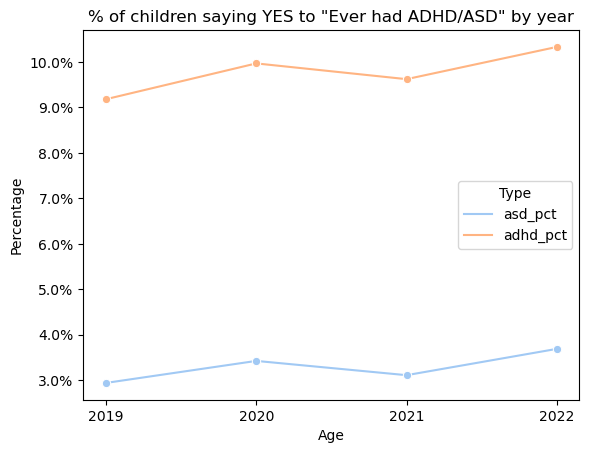

In [11]:
def percentage_formatter(x, pos):
    return f'{(x * 100):.1f}%'

melted_df = pd.melt(dfcall_yearly, id_vars=['year'], value_vars=['asd_pct', 'adhd_pct'], var_name='Type', value_name='Value')
ax = sns.lineplot(x='year', y='Value', hue='Type', data=melted_df, palette='pastel',marker='o')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('% of children saying YES to "Ever had ADHD/ASD" by year')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(range(2019,2023,1))

plt.show()

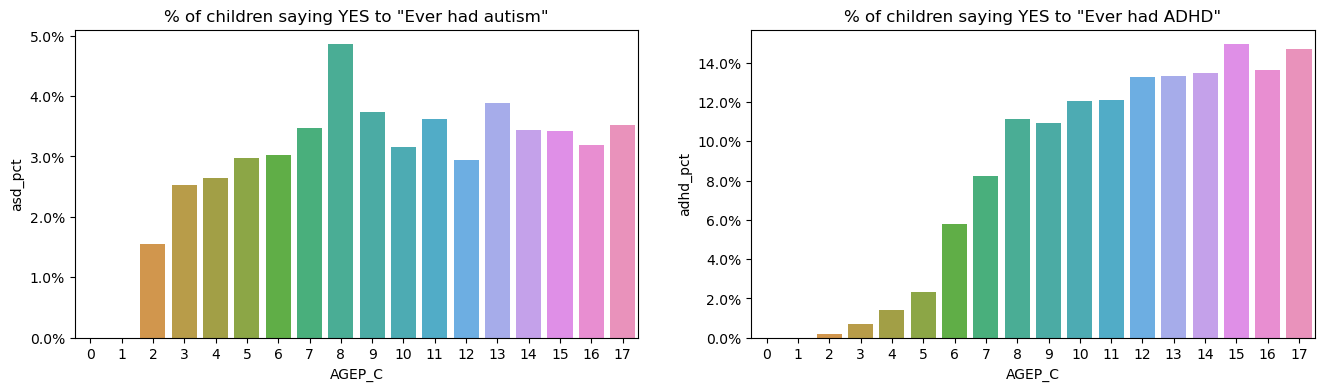

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (16,4))

# Autistic percentage by age
dfc_asd_age = pd.DataFrame(dfcall.groupby('AGEP_C')['ASDEV_C'].apply(lambda x: (x==1.0).sum())).reset_index()
dfc_asd_age.rename({'ASDEV_C' : 'asd_count'},axis=1,inplace=True)
dfc_asd_age['all_count'] = dfcall.groupby('AGEP_C')['AGEP_C'].count()
dfc_asd_age['asd_pct'] = dfc_asd_age['asd_count'] / dfc_asd_age['all_count']
sns.barplot(dfc_asd_age,x='AGEP_C',y='asd_pct',ax=axes[0])
axes[0].yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
axes[0].set_title('% of children saying YES to "Ever had autism"')


# adhd percentage by age
dfc_adhd_age = pd.DataFrame(dfcall.groupby('AGEP_C')['ADHDEV_C'].apply(lambda x: (x==1.0).sum())).reset_index()
dfc_adhd_age.rename({'ADHDEV_C' : 'adhd_count'},axis=1,inplace=True)
dfc_adhd_age['all_count'] = dfcall.groupby('AGEP_C')['AGEP_C'].count()
dfc_adhd_age['adhd_pct'] = dfc_adhd_age['adhd_count'] / dfc_adhd_age['all_count']
sns.barplot(dfc_adhd_age,x='AGEP_C',y='adhd_pct',ax=axes[1])
axes[1].yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
axes[1].set_title('% of children saying YES to "Ever had ADHD"')


# Apply the formatter to the y-axis
#plt.xlabel('Age')
#plt.ylabel('Percentage')





plt.show()

### Observations
* %-age of children identified as having/had ADHD increases by age, though likely plateau's at some point 


## Correlation analysis (WIP)

### Pearson correlation
Since ADHDEV_C and ASDEV_C is heavily skewed, we will do few rounds of random sampling with same distribution for each label, and then take average for the correlations. 

In [16]:
# ADHD
rounds = 10

dfcall_temp = dfcall.drop(columns=['HHX']).fillna(value=0)
dfc_asd = dfcall[dfcall['ASDEV_C']==1.0].drop(columns=['HHX'])
dfc_non_asd = dfcall[dfcall['ASDEV_C']==0.0].drop(columns=['HHX'])

for i in range(0,rounds): 
    dfc_non_asd_sampled = dfc_non_asd.sample(n=dfc_asd.shape[0]) 
    dfc_combined = pd.concat([dfc_asd,dfc_non_asd_sampled],axis=0)
    if i == 0:
        dfc_corr = dfc_combined.corrwith(dfc_combined['ASDEV_C']).sort_values(ascending=False).reset_index()
    else:
        dfc_corr = pd.concat([dfc_corr,dfc_combined.corrwith(dfc_combined['ASDEV_C']).sort_values(ascending=False).reset_index()],axis=0)

        
def custom_agg(group):
    return pd.Series({
        'corr_mean': group[0].mean(),
        'corr_stdev': group[0].std()
    })
dfc_corr_summary = dfc_corr.groupby(['index']).apply(custom_agg).sort_values('corr_mean',ascending=False).reset_index()
dfc_corr_summary['Description'] = pd.merge(dfc_corr_summary, cookbook_child, left_on='index', right_on='Variable Name')['Description']

dfc_corr_summary


,index,corr_mean,corr_stdev,Description
0,ASDEV_C,1.000000,0.000000,Ever had autism
1,SCHSPEDEV_C,0.718384,0.008062,Ever received special education
2,BEHDFCHG_C,0.610208,0.013191,Difficulty with changes in routine
3,SDQTOT_C,0.602616,0.014248,SDQ total score
4,SDQIMP1_C,0.600171,0.012341,"Difficulties with emotions, behaviors"
5,SDQHYPE_C,0.591253,0.013307,Hyperactivity Subscale Score
6,UNDRSTCHD_C,0.585663,0.025364,Respondent's difficulty understanding child
7,UNDRSTYOU_C,0.560052,0.013495,Child's difficulty understanding respondent
8,LEARNDF_C,0.545202,0.007483,Difficulty learning things
9,SDQ15_C,0.524247,0.015944,Easily distracted


In [17]:
# Autism
rounds = 10

dfcall_temp = dfcall.drop(columns=['HHX']).fillna(value=0)
dfc_asd = dfcall[dfcall['ADHDEV_C']==1.0].drop(columns=['HHX'])
dfc_non_asd = dfcall[dfcall['ASDEV_C']==0.0].drop(columns=['HHX'])

for i in range(0,rounds): 
    dfc_non_asd_sampled = dfc_non_asd.sample(n=dfc_asd.shape[0]) 
    dfc_combined = pd.concat([dfc_asd,dfc_non_asd_sampled],axis=0)
    if i == 0:
        dfc_corr = dfc_combined.corrwith(dfc_combined['ADHDEV_C']).sort_values(ascending=False).reset_index()
    else:
        dfc_corr = pd.concat([dfc_corr,dfc_combined.corrwith(dfc_combined['ADHDEV_C']).sort_values(ascending=False).reset_index()],axis=0)

        
def custom_agg(group):
    return pd.Series({
        'corr_mean': group[0].mean(),
        'corr_stdev': group[0].std()
    })
dfc_corr_summary = dfc_corr.groupby(['index']).apply(custom_agg).sort_values('corr_mean',ascending=False).reset_index()
dfc_corr_summary['Description'] = pd.merge(dfc_corr_summary, cookbook_child, left_on='index', right_on='Variable Name')['Description']

dfc_corr_summary


,index,corr_mean,corr_stdev,Description
0,ADHDEV_C,1.000000,6.409876e-17,Ever had ADD/ADHD
1,SDQHYPE_C,0.613309,6.107344e-03,Hyperactivity Subscale Score
2,SDQ15_C,0.599287,5.898585e-03,Easily distracted
3,SDQIMP1_C,0.558660,1.151943e-02,"Difficulties with emotions, behaviors"
4,SDQTOT_C,0.534975,8.824222e-03,SDQ total score
5,SDQ2_C,0.475522,7.395862e-03,"Restless, cannot stay still"
6,SCHSPEDEV_C,0.467978,6.296768e-03,Ever received special education
7,SDQ10_C,0.445596,1.000914e-02,Constantly fidgeting/squirming
8,BEHDFCNTR_C,0.398015,4.239949e-03,Difficulty controlling behavior
9,UNDRSTYOU_C,0.384187,4.534019e-02,Child's difficulty understanding respondent


### Observations

* For ASD, top notable correlated behavioral questions were:
   * Difficulty with changes in routine
   * Difficulties with emotions, behaviors
   * Respondent's difficulty understanding child
   * Child's difficulty understanding respondent
   * Difficulty learning things
   * Easily distracted
   * Difficulty making friends
   * Difficulty controlling behavio
   * Difficulty playing
* For ADHD, top notable correlated behavioral questions were:
   * Easily distracted
   * Difficulties with emotions, behaviors
   * Restless, cannot stay still
   * Constantly fidgeting/squirming
   * Difficulty controlling behavior
   * Child's difficulty understanding respondent
   * Difficulty with changes in routine
   * Difficulty learning things
   * Difficulty playing
   * Ever had learning disability
* There are definitely similar patterns between the two, but with ADHD having more specific correlation such as restlessness or fidgeting
* Note that most of the variables are binary or discrete, so pearson correlation may not be the best use. However in this context we are just looking at relative rank differences so we will only look at pearson's

# ETCs

Past analysis with non-notable outcomes

In [ ]:
# Is ihe increase in ADD/ADHD differ by year? 
def custom_agg(group):
    return pd.Series({
        'adhd_count': group['ADHDEV_C'].sum(),
        'all_count': group['AGEP_C'].count()
    })
dfc_adhd_age = pd.DataFrame(dfcall.groupby(['AGEP_C','SRVY_YR']).apply(custom_agg)).reset_index()
dfc_adhd_age['adhd_pct'] = dfc_adhd_age['adhd_count'] / dfc_adhd_age['all_count']

ax = sns.lineplot(x='AGEP_C', y='adhd_pct', hue='SRVY_YR', data=dfc_adhd_age, palette='flare',marker='o')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('% of children saying YES to "Ever had ADHD/ASD" by year')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(range(0,18,1))

plt.show()

#Don't really see clear pattern